In [93]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt
from scipy.interpolate import RBFInterpolator

Load in calibration images

In [94]:
buffer = 0
uncropped_img = cv2.imread('mimage.png')
offset = 175
img = uncropped_img[:, offset:-300]

Defines function to display image

In [95]:
def disp(img):
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image_rgb)

Defines function to automatically detect as many corners as possible

In [96]:
def getCorners(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    corners, quality = cv2.goodFeaturesToTrackWithQuality(gimg, maxCorners=200, qualityLevel=0.10, minDistance=7, mask=None)
    return corners

Defines function to display corners

In [97]:
def displayCorners(img, corners, nums=True):
    _img = img.copy()
    for i in range(len(corners)):
        point = corners[i]
        cv2.circle(_img,(int(point[0][0]),int(point[0][1])),3,(0,0,255),-1)
        if nums:
            cv2.putText(_img,str(i),(int(point[0][0]),int(point[0][1])-2),0,0.5,(0,0,255))

    disp(_img)

Define Radial Basis Function

In [98]:
def getRBF(actual_corners, ideal_corners, additional_points):
    print(ideal_corners.shape)
    print(actual_corners.shape)

    filter = actual_corners[:,0,0] != -1.

    ideal_pair = np.squeeze(ideal_corners, axis=1)[filter]
    print(ideal_pair.dtype, ideal_pair.shape)

    actual_x = actual_corners[filter][:,0,0]
    print(actual_x.dtype, actual_x.shape)

    actual_y = actual_corners[filter][:,0,1]

    if additional_points is not None:
        actual_additional_points = additional_points[0]
        ideal_additional_points = additional_points[1]

        ideal_pair = np.concatenate((ideal_pair, ideal_additional_points))
        print("ideal", ideal_pair[-2:])

        actual_x = np.concatenate((actual_x, actual_additional_points[:,0]))
        print("actual x", actual_x[-2:])

        actual_y = np.concatenate((actual_y, actual_additional_points[:,1]))
        print("actual y", actual_y[-2:])

    rbf_x = RBFInterpolator(ideal_pair, actual_x)
    rbf_y = RBFInterpolator(ideal_pair, actual_y)

    return rbf_x, rbf_y, filter

Map image according coeficients

In [99]:
def undistort(img, new_shape, actual_corners, ideal_corners, additional_points=None):
    old_shape = img.shape[:2]
    fun_x, fun_y, filter = getRBF(actual_corners, ideal_corners, additional_points)

    x_off = 0 #old_shape[0] - new_shape[0]
    y_off = 0 #old_shape[1] - new_shape[1]

    map_x = np.zeros(new_shape, dtype=np.float32)
    map_y = np.zeros(new_shape, dtype=np.float32)
    for i in range(map_x.shape[0]):
        for j in range(map_x.shape[1]):
            map_x[i,j] = fun_x(np.array([[j+x_off, i+y_off]]))
            map_y[i,j] = fun_y(np.array([[j+x_off, i+y_off]]))

    return map_x, map_y, filter

Find potential corners

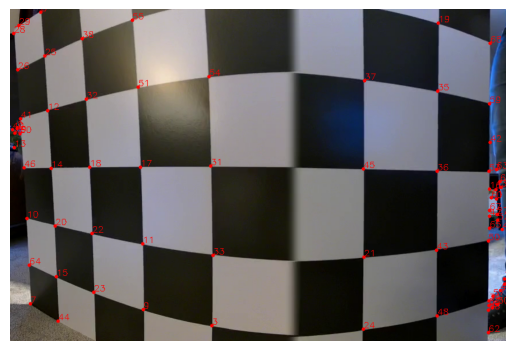

In [100]:
grid_height, grid_width = 7, 9

corn = getCorners(img)
displayCorners(img, corn)

Manually keep correct corners

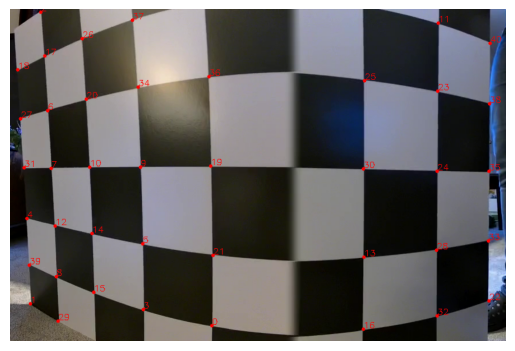

In [101]:
keep = [8,
        26, 25, 38, 55, 19, 68,
        41, 12, 32, 51, 54, 37, 35, 59,
        46, 14, 18, 17, 31, 45, 36, 53,
        10, 20, 22, 11, 33, 21, 43, 50,
        64, 15, 23, 9, 3, 24, 48, 34,
        7, 44]

mask = [False]*len(corn)
for k in keep:
    mask[k] = True
corn_n = corn[mask]

displayCorners(img, corn_n)

Lineup the indexes of the actual corners

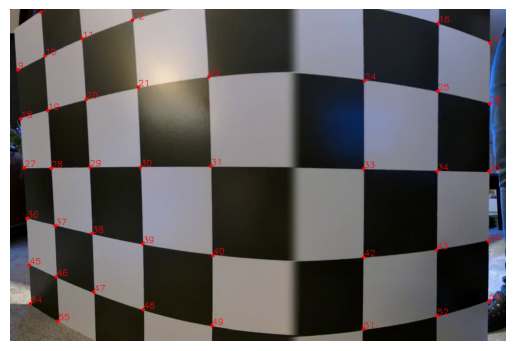

In [102]:
actual_corners = np.zeros((grid_height*grid_width, 1, 2))-1
map = {2:1,
       18:9, 17:10, 26:11, 37:12, 11:16, 40:17,
       27:18, 6:19, 20:20, 34:21, 36:22, 25:24, 23:25, 38:26,
       31:27, 7:28, 10:29, 9:30, 19:31, 30:33, 24:34, 35:35,
       4:36, 12:37, 14:38, 5:39, 21:40, 13:42, 28:43, 33:44,
       39:45, 8:46, 15:47, 3:48, 0:49, 16:51, 32:52, 22:53,
       1:54, 29:55}


assert (sorted(list(map.keys())) == list(range(len(corn_n)))), "map does not map all detected corner points"

for i in range(len(corn_n)):
    actual_corners[map[i]] = corn_n[i]

displayCorners(img, actual_corners)

Add Aditional Corners

(576, 861, 3)


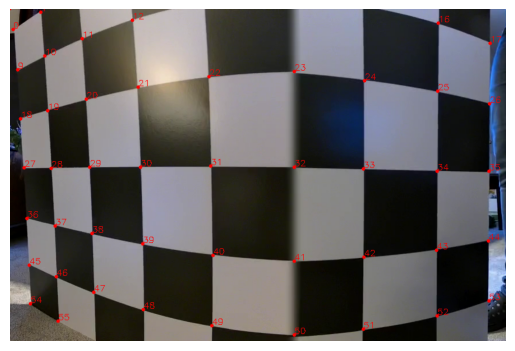

In [103]:
print(img.shape)
actual_corners[0] = np.array([[180-offset, 35]])
actual_corners[23] = np.array([[668-offset, 108]])
actual_corners[32] = np.array([[668-offset, 274]])
actual_corners[41] = np.array([[668-offset, 437]])
actual_corners[50] = np.array([[668-offset, 565]])

displayCorners(img, actual_corners)

Create ideal corner points

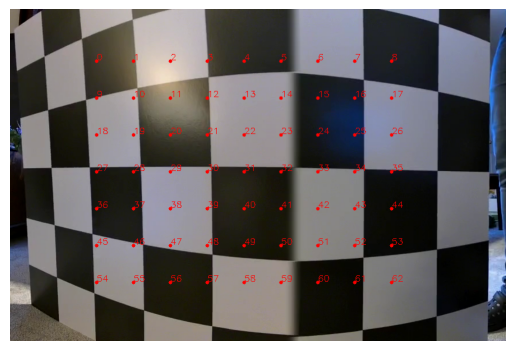

In [104]:
block_len = 64
height, width, _ = img.shape
ideal_corners = np.zeros((grid_height*grid_width, 1, 2))
start = np.array([150, 90])

for i in range(grid_height):
    for j in range(grid_width):
        ideal_corners[grid_width*i + j, 0] = start
        start[0] += block_len
    start[1] += block_len
    start[0] -= block_len*grid_width

displayCorners(img, ideal_corners)

Combine Callibration Mtarix

(1728, 3528, 3) uint8
(8640, 17640, 3) uint8


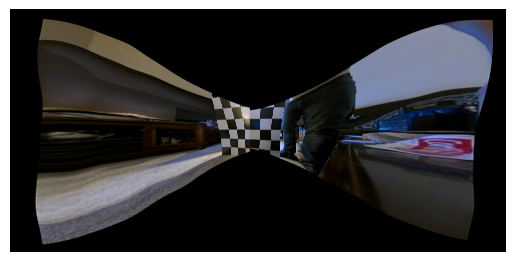

In [105]:
scale = 3
width = uncropped_img.shape[1]

lmap = np.load('./calibration_np/left_calibration.npy')
limg = uncropped_img[:, :width//2]
lper = cv2.remap(limg, lmap, None, cv2.INTER_CUBIC)[:,:-100*scale]

rmap = np.load('./calibration_np/right_calibration.npy')
rimg = uncropped_img[:, width//2:]
rper = cv2.remap(rimg, rmap, None, cv2.INTER_CUBIC)[:,60*scale:]

per = np.concatenate((lper, rper), axis=1)
scale = 5
shape = (int(scale * per.shape[1]), int(scale * per.shape[0]))
print(per.shape, per.dtype)
per = cv2.resize(per, shape, interpolation=cv2.INTER_CUBIC)
print(per.shape, per.dtype)

disp(per)

(1728, 1806, 2)
(1728, 1806, 2)


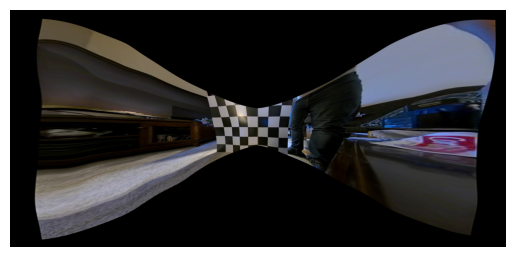

In [106]:
scale = 3
lmap = np.load('./calibration_np/left_calibration.npy')[:,:-66*scale]
rmap = np.load('./calibration_np/right_calibration.npy')[:,60*scale:-6*scale]
print(rmap.shape)
print(lmap.shape)
rmap[:,:,0] += 668
map = np.concatenate((lmap, rmap), axis=1)


per = cv2.remap(uncropped_img, map, None, cv2.INTER_CUBIC)
disp(per)

In [107]:
np.save('./calibration_np/full_calibration.npy', map)

Add Additional Points

In [108]:
additional_points = None

Get Callibration Matrix

In [109]:
map_x, map_y, filter = undistort(img, img.shape[:2], actual_corners, ideal_corners, additional_points)
map = np.stack((map_x, map_y), axis=2)

(63, 1, 2)
(63, 1, 2)
float64 (46, 2)
float64 (46,)


Reverse calibration

In [110]:
def compute_inverse_map(map, original_shape):
    remapped_height, remapped_width = map.shape[:2]
    original_height, original_width = original_shape[:2]

    # Initialize inverse map with the same shape as the original image
    inverse_map_x = np.full((original_height, original_width), -1, dtype=np.int16)
    inverse_map_y = np.full((original_height, original_width), -1, dtype=np.int16)

    # Iterate through each pixel in the remapped image and find where it maps in the original image
    for y in range(remapped_height):
        for x in range(remapped_width):
            # Get the corresponding original image coordinates from the remapped image
            orig_x = map[y, x, 0]
            orig_y = map[y, x, 1]

            # Ensure the coordinates are within the bounds of the original image
            if 0 <= orig_x < original_width and 0 <= orig_y < original_height:
                # Assign the inverse mapping
                inverse_map_x[int(orig_y), int(orig_x)] = x
                inverse_map_y[int(orig_y), int(orig_x)] = y

    # Find unassigned points (marked by -1)
    mask = (inverse_map_x == -1) | (inverse_map_y == -1)

    # Apply distance transform to find the nearest assigned point for each unassigned point
    _, nearest_idx = distance_transform_edt(mask, return_indices=True)

    # Use the nearest valid coordinates to fill in the gaps
    inverse_map_x[mask] = inverse_map_x[nearest_idx[0][mask], nearest_idx[1][mask]]
    inverse_map_y[mask] = inverse_map_y[nearest_idx[0][mask], nearest_idx[1][mask]]

    # Stack inverse_map_x and inverse_map_y into a single array
    inverse_map = np.stack([inverse_map_x, inverse_map_y], axis=-1)

    return inverse_map

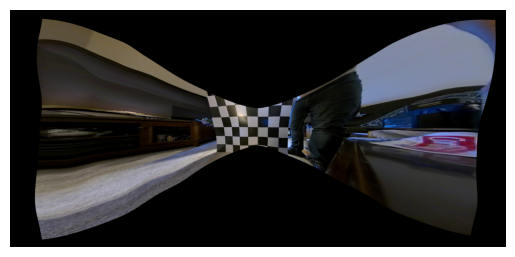

In [160]:
map = np.load('./calibration_np/full_calibration.npy')

remapped_image = cv2.remap(uncropped_img, map, None, cv2.INTER_NEAREST)
disp(remapped_image)

(1728, 3612, 2) (576, 1336, 2)


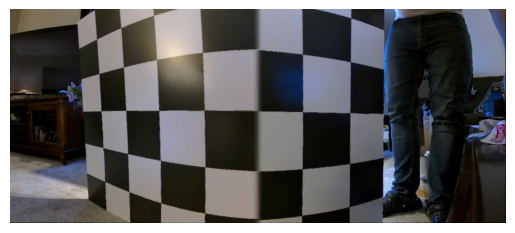

In [112]:
inverse_map = compute_inverse_map(map, uncropped_img.shape)
print(map.shape, inverse_map.shape)

restored_image = cv2.remap(remapped_image, inverse_map, None, cv2.INTER_NEAREST)
disp(restored_image)

(0,)


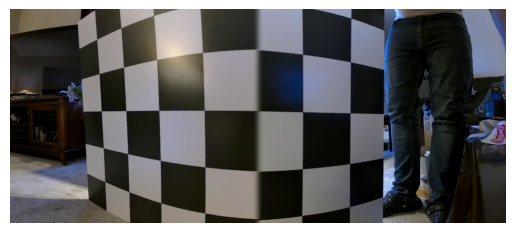

In [113]:
disp(uncropped_img)
print((inverse_map[np.isnan(inverse_map)]).shape)

Transform actual points to initial image calibration

[[-1. -1.]]


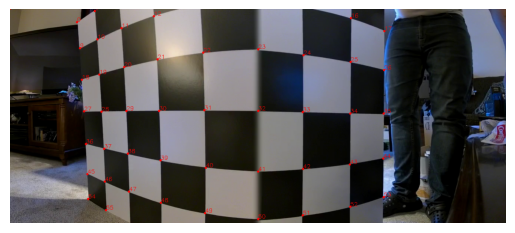

In [118]:
shifted_actual_corners = actual_corners.copy()
shifted_actual_corners[:,:,0][filter] += offset

displayCorners(uncropped_img, shifted_actual_corners)
print(shifted_actual_corners[56])

(576, 1336, 2) (46, 1, 2)
[[[ 1.431e+03  6.340e+02]]

 [[ 1.489e+03  6.290e+02]]

 [[-1.000e+00 -1.000e+00]]]
[[-1. -1.]]


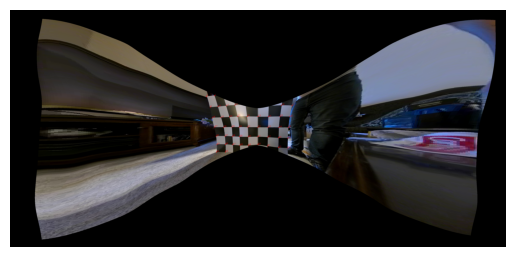

In [123]:
print(inverse_map.shape, shifted_actual_corners[filter].shape)
calibrated_actual_points = np.zeros_like(shifted_actual_corners)
for corner, calibrated_corner, fil in zip(shifted_actual_corners, calibrated_actual_points, filter):
    if fil:
        calibrated_corner[0] = inverse_map[int(corner[0,1]), int(corner[0,0])]
    else:
        calibrated_corner[0] = [-1, -1]
print(calibrated_actual_points[:3])

displayCorners(remapped_image, calibrated_actual_points)
print(calibrated_actual_points[56])

(1728, 3612, 3)
[[[1468.  655.]]

 [[1535.  655.]]

 [[1602.  655.]]]


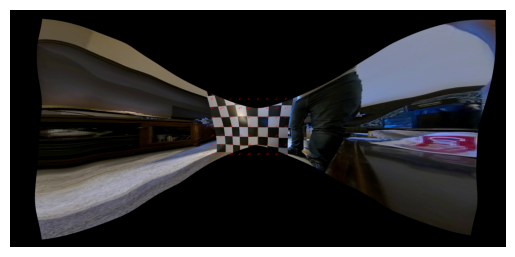

In [155]:
print(remapped_image.shape)
calibrated_ideal_corners = ideal_corners.copy()
calibrated_ideal_corners += (42,38)
calibrated_ideal_corners /= 64

calibrated_ideal_corners *= 67
calibrated_ideal_corners += (1267, 521)

print(calibrated_ideal_corners[:3])

displayCorners(remapped_image, calibrated_ideal_corners)

Display Undistorted Image

In [161]:
map_x, map_y, filter = undistort(remapped_image, remapped_image.shape[:2], calibrated_actual_points, calibrated_ideal_corners, None)
map2 = np.stack((map_x, map_y), axis=2)

(63, 1, 2)
(63, 1, 2)
float64 (46, 2)
float64 (46,)


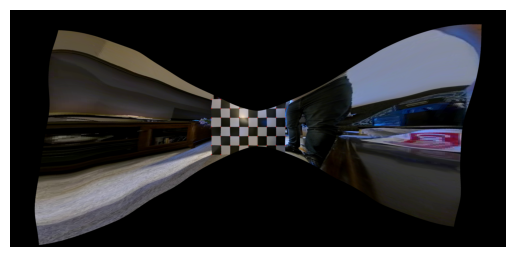

In [162]:
per = cv2.remap(remapped_image, map2, None, cv2.INTER_CUBIC)
displayCorners(per, calibrated_ideal_corners[filter], False)

(1728, 3612, 2)
[-39.213543 576.75256 ]


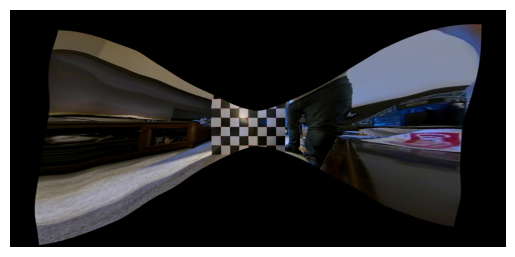

In [173]:
map_final = cv2.remap(map, map2, None, cv2.INTER_NEAREST, borderValue=-1)
print(map_final.shape)
print(map_final[1727,0])
per = cv2.remap(uncropped_img, map_final, None, cv2.INTER_CUBIC)
displayCorners(per, calibrated_ideal_corners[filter], False)

Decide to add additional points

(576, 668, 3)
[[ 60. 282.]]
[[[  5.   0.]
  [  5. 576.]]

 [[ 60. 240.]
  [ 60. 340.]]]


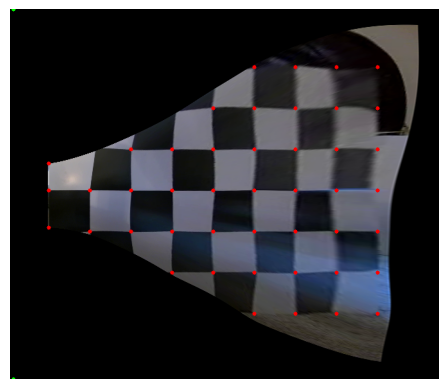

In [234]:
ideal_point1 = [60, 240]
actual_point1 = [5, 0]
ideal_point2 = [60, 340]
print(img.shape)
actual_point2 = [5, img.shape[0]]
print(ideal_corners[27])
_img = per.copy()

_img = cv2.circle(_img, ideal_point1, 3, (0,0,255), -1)
_img = cv2.circle(_img, actual_point1, 3, (0,255,0), -1)

_img = cv2.circle(_img, ideal_point2, 3, (0,0,255), -1)
_img = cv2.circle(_img, actual_point2, 3, (0,255,0), -1)
displayCorners(_img, ideal_corners[filter], False)

additional_points = np.array([[actual_point1, actual_point2], [ideal_point1, ideal_point2]], dtype=np.float64)
print(additional_points)

Save Callibration

In [174]:
np.save('./calibration_np/full_calibration.npy', map_final)